# k-Nearest Neighbour experiment

## Load data

In [4]:
from imbatcher.Decoder import Decoder


paths = ["/home/yordwynn/Image/screenshots/true/",
         "/home/yordwynn/Image/screenshots/false/"]
labels = [1, 0]
data = Decoder.decode_png_images(paths, labels, 0.4)
x_data = data["data"]
y_data = data["labels"]

## Print data

Print 5 positive and 5 negative random images

(594,)


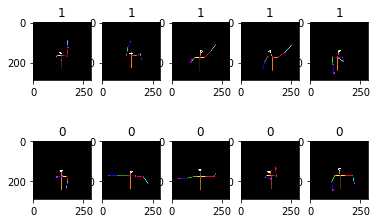

In [5]:
import numpy as np
import matplotlib.pyplot as plt

samples_per_class = 5
num_classes = len(labels)

y_data = np.array(y_data).reshape(-1)
print(y_data.shape)
x_data = np.array(x_data)

for y, item in enumerate(labels):
    idxs = np.flatnonzero(y_data == item)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        image = x_data[idxs[i]]
        image = image.reshape(288, 288, 3)
        label = y_data[idxs[i]]
        plt.subplot(num_classes, samples_per_class, i + 1 + y * samples_per_class)
        plt.imshow(image)
        plt.title(label)
        
plt.show()

## Search the best parameters for uniform weights

In [6]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3, algorithm="kd_tree")
neigh.fit(x_data, y_data)
print(neigh.predict_proba([x_data[102]]))

[[0.66666667 0.33333333]]


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


classifier = KNeighborsClassifier(algorithm="kd_tree")
param_grid = {"weights": ["uniform", "distance"],
              "metric": ["euclidean", "manhattan"],
              "n_neighbors": range(1, 3)}
scoring = {"accuracy": make_scorer(accuracy_score),
           "precision": make_scorer(precision_score),
           "recall": make_scorer(recall_score)}

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring, cv=3,
                  refit='accuracy', return_train_score=True, iid=False)
gs.fit(x_data, y_data)
results = gs.cv_results_
print(results)

{'mean_fit_time': array([2.21877186, 2.08330146, 2.20348461, 2.16911976, 2.16300305,
       2.18876394, 2.13769031, 2.21217505]), 'std_fit_time': array([0.09496682, 0.02003621, 0.09634642, 0.02194375, 0.0684804 ,
       0.09022796, 0.06462151, 0.13438739]), 'mean_score_time': array([77.77574825, 77.07461731, 76.05742868, 77.67179163, 76.22889614,
       75.4721458 , 74.60277088, 75.39272173]), 'std_score_time': array([0.117087  , 0.9479402 , 0.58150456, 0.42816697, 0.37193276,
       0.7965022 , 0.6582759 , 1.36072464]), 'param_metric': masked_array(data=['euclidean', 'euclidean', 'euclidean', 'euclidean',
                   'manhattan', 'manhattan', 'manhattan', 'manhattan'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_neighbors': masked_array(data=[1, 1, 2, 2, 1, 1, 2, 2],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object

In [15]:
print(gs.best_estimator_)
print(gs.best_params_)
print(gs.best_score_)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')
{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.5405915732931522


## Show heatmap for the best weight

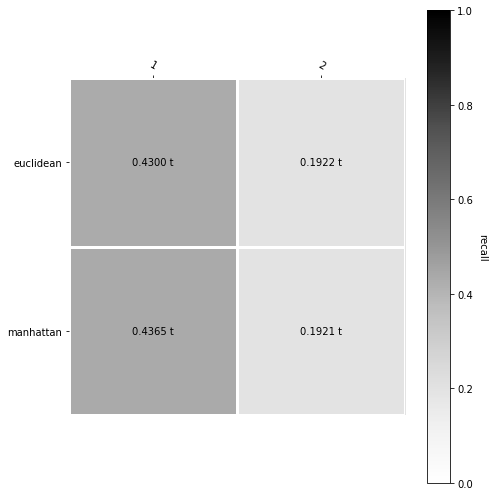

In [55]:
from heat_map import heatmap, annotate_heatmap

weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan"]
n_neighbors = range(1, 3)

mean_test_recall = results['mean_test_recall']
mean_test_recall = mean_test_recall.reshape((2, 2, 2))
mean_test_recall = mean_test_recall.transpose(2, 0, 1)
mean_test_recall = mean_test_recall[0]


plt.rcParams["figure.figsize"]=[7, 7]
fig, ax = plt.subplots()

im, cbar = heatmap(mean_test_recall, metric, n_neighbors, ax=ax,
                   cmap="Greys", vmin=0, vmax=1, cbarlabel="recall")
texts = annotate_heatmap(im, valfmt="{x:.4f} t", textcolors=["black", "white"], threshold=0.5)

fig.tight_layout()
plt.show()

## Show plot for each metric

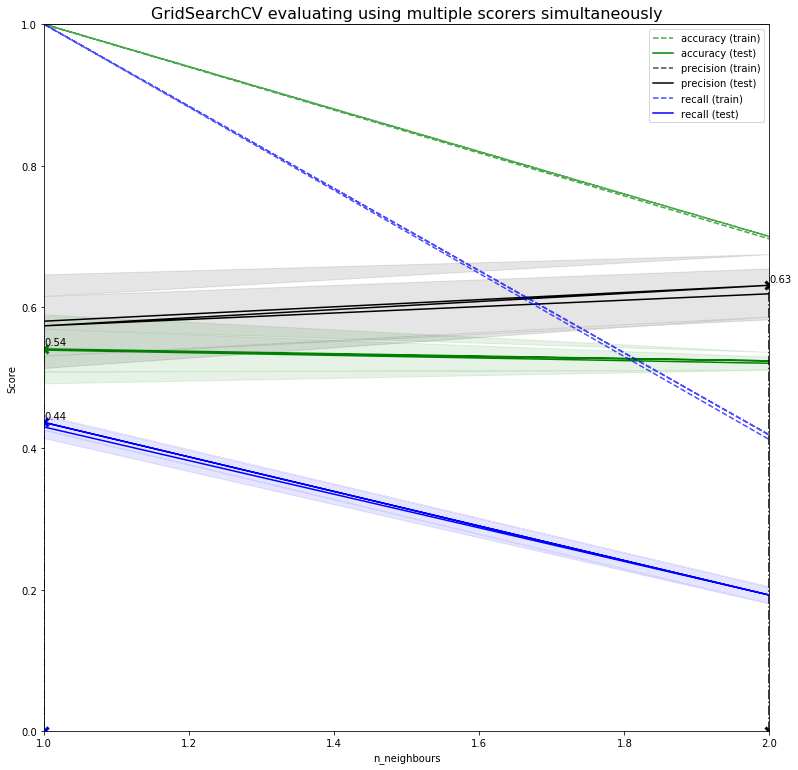

In [10]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("n_neighbours")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(1, 2)
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_neighbors'].data, dtype=int)

for scorer, color in zip(sorted(scoring), ['g', 'k', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()